In [1]:
import sys
import os
import pandas as pd
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import download
import warnings
import nltk

warnings.filterwarnings(action = 'ignore')
 
import gensim
from gensim.models import Word2Vec
from curses.ascii import isalpha
from gensim.models import KeyedVectors


from nltk.corpus import stopwords
spanish_stop_words = set(stopwords.words('spanish'))


import seaborn as sns
import matplotlib.pyplot as plt

# Import adjustText, initialize list of texts
from adjustText import adjust_text

from sklearn.manifold import TSNE


In [10]:
# cambiar url para leer los datos de otro subfolder con path relativo
# os.chdir('../')

# Descarga de archivos nltk necesarios para modelar, descargue todo
# download()

In [3]:
noticias = pd.read_csv('../datos/noticias.csv')

In [4]:
noticias.columns

Index(['news_id', 'news_url_absolute', 'news_init_date', 'news_final_date',
       'news_title', 'news_text_content'],
      dtype='object')

In [5]:
noticias['len_titular'] = noticias['news_title'].apply(lambda x: len(x))
noticias['len_content'] = noticias['news_text_content'].apply(lambda x: len(x))

In [6]:
noticias.sort_values('len_content',ascending=False).head(5)

,news_id,news_url_absolute,news_init_date,news_final_date,news_title,news_text_content,len_titular,len_content
1215,news14869,https://www.dclm.es/noticias/118157/las-empres...,2022-07-15,2022-07-30,LAS EMPRESAS ANTE A LA REACTIVACION ECONOMICA ...,El sector servicios elevo su facturacion un 1...,49,1557039
8548,news42765,https://www.derecho.com/boe/orden-efp7542022-d...,2022-07-30,2022-08-14,"Orden EFP/754/2022, de 28 de julio, por la que...","La Ley Organica 2/2006, de 3 de mayo, de Educa...",63,1441609
11953,news56108,https://centralelectoral.ine.mx/2022/07/21/ver...,2022-07-15,2022-07-30,Version estenografica de la Sesion Extraordina...,VERSION ESTENOGRAFICA PRELIMINAR DE LA SESION ...,57,354396
1550,news16102,https://www.infobae.com/cultura/agenda-cultura...,2022-07-15,2022-07-30,Guia de Arte y Cultura: semana del 22 al 29 de...,"ARTE Natalia Cacchiarelli, Muestra Numero Doce...",52,330834
12142,news56811,https://www.dclm.es/noticias/127814/el-espacio...,2022-07-15,2022-07-30,EL ESPACIO DE LA disCAPACIDAD JULIO (Castilla-...,"Por primera vez, una pareja de manchegos de A...",52,330045


# Funciones

In [7]:
def create_tokenization(x):
    data = []
    for j in word_tokenize(x,language='spanish'):
        term = j.lower()

        if term.isalpha() and not term in spanish_stop_words:
            data.append(term)
    return data

def document_vector(word2vec_model, doc, vocab):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in vocab]
    return np.mean(word2vec_model.wv[doc], axis=0)

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(vocab, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc,vocab):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if has_vector_representation(vocab,doc)]

    corpus = [doc for doc in corpus if has_vector_representation(vocab,doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [8]:
data = noticias['news_text_content'].apply(create_tokenization)
data_titulas = noticias['news_title'].apply(create_tokenization)

In [9]:
# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count = 1,
                              vector_size = 100, window = 5)

model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100,
                                             window = 5, sg = 1)

In [17]:
palabra1 = 'reputacion'
palabra2 = 'fama'

In [18]:
print(model1.wv.similarity(palabra1,palabra2))
print(model2.wv.similarity(palabra1,palabra2))

0.38742584
0.5752188


In [93]:
macroeconomia = model2.wv['macroeconomia']

In [10]:
vocab = list(model2.wv.index_to_key)

In [177]:
id = 1550
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model2.wv[word] for word in data[id] if word in vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in data[id] if word in vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

In [178]:
# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

In [179]:
print(df.shape)

(8879, 100)


In [182]:

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 3)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

IndexError: index 400 is out of bounds for axis 0 with size 400

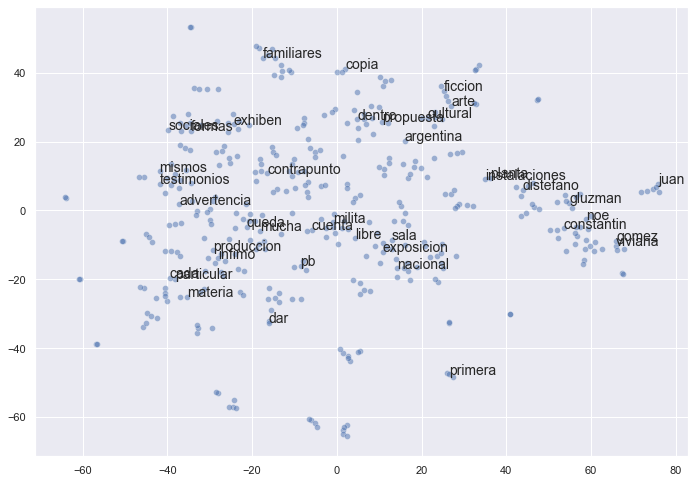

In [183]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
words_to_plot = list(np.arange(0, df.shape[0], 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [213]:
titles_list = list(noticias['news_title'])

x = []
for doc in data_titulas: # append the vector for each document
    try:
        output = document_vector(model2, doc, vocab=vocab)
    except:
        output = None
    x.append(output)
    
lista_val = [i for i in range(len(x)) if x[i] is None]

lista_val_clean = [i for i in range(len(x)) if i not in lista_val]

x = [x[i] for i in lista_val_clean]
titles_list = [titles_list[i] for i in lista_val_clean]

X = np.array(x) # list to array

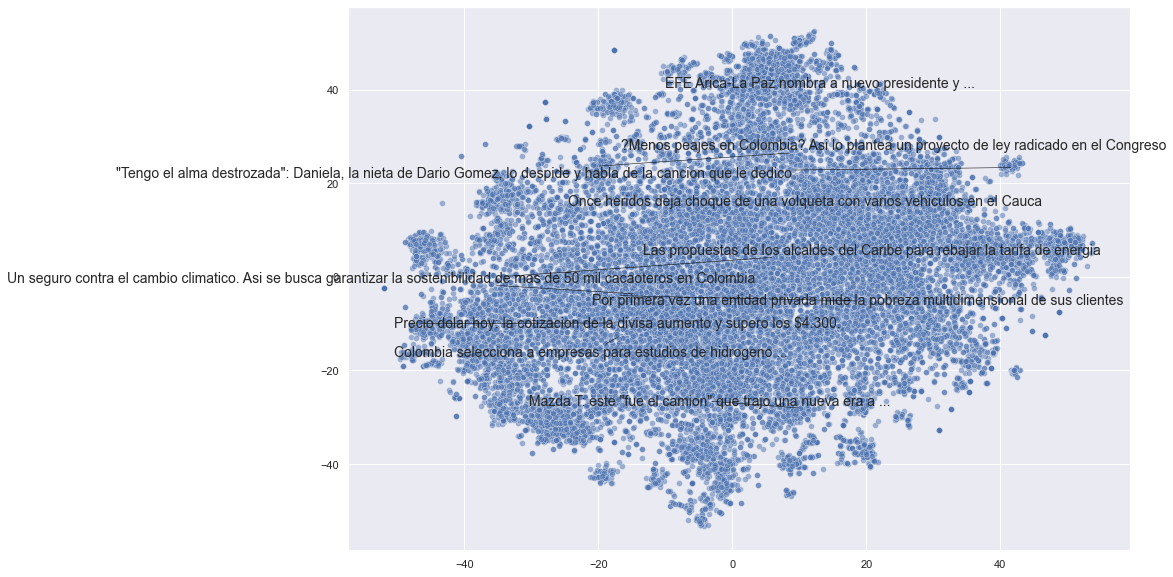

In [218]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 800, 80)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


# Prueba con Top 10 de palabra por noticia

In [11]:
content_news_list = list(noticias['news_text_content'])

top_terms = []
x_top = []

for doc in data: # append the vector for each document
    
    dict_final = nltk.FreqDist(doc)
    term = take(10,dict(dict_final))

    doc = [sub_doc for sub_doc in doc if sub_doc in term]
    
    top_terms.append(doc)
    
    try:
        output = document_vector(model2, doc, vocab=vocab)
    except:
        output = None
    x_top.append(output)
    
lista_val = [i for i in range(len(x_top)) if x_top[i] is None]
lista_val_clean = [i for i in range(len(x_top)) if i not in lista_val]

x_top = [x_top[i] for i in lista_val_clean]
top_terms = [top_terms[i] for i in lista_val_clean]

content_news_list = [content_news_list[i] for i in lista_val_clean]

content_news_list = np.array(x_top)

In [12]:
top_terms_final = [list(set(sub_doc)) for sub_doc in top_terms]

In [14]:
top_terms_text = [','.join(i) for i in top_terms_final]

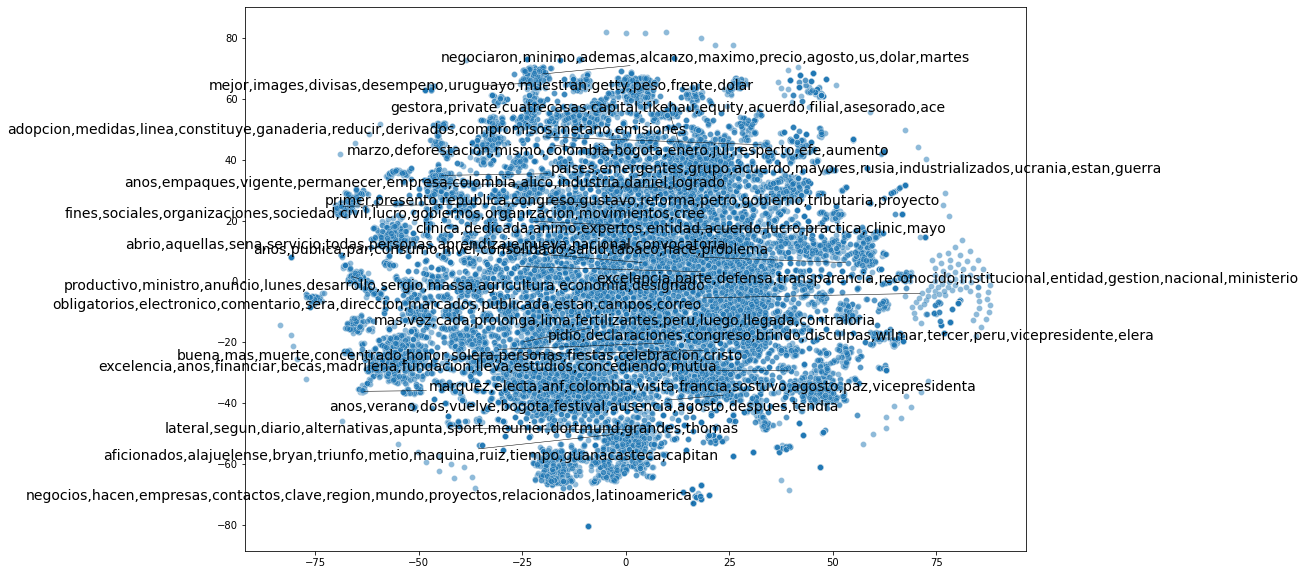

In [45]:
subset_limit = content_news_list.shape[0]

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 2022, perplexity = 40)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(content_news_list[:subset_limit])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, subset_limit, 1000)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], top_terms_text[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Text(0, 0.5, 'Inertia')

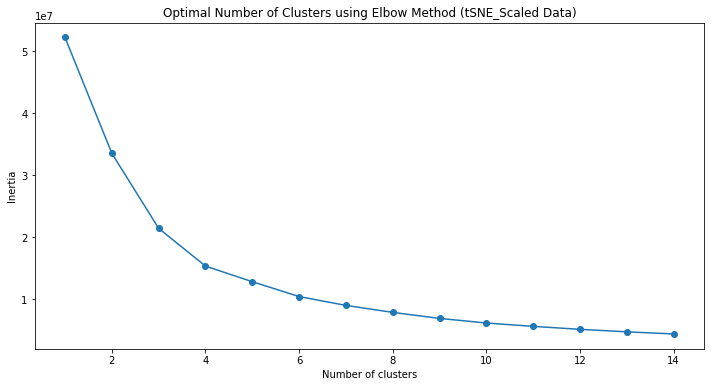

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [53]:
from sklearn.metrics import silhouette_score

kmeans_tsne_scale = KMeans(n_clusters=6, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_

KMeans tSNE Scaled Silhouette Score: 0.3589571416378021


In [54]:
clusters_tsne_scale = pd.concat([pd.DataFrame(tsne_df), pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

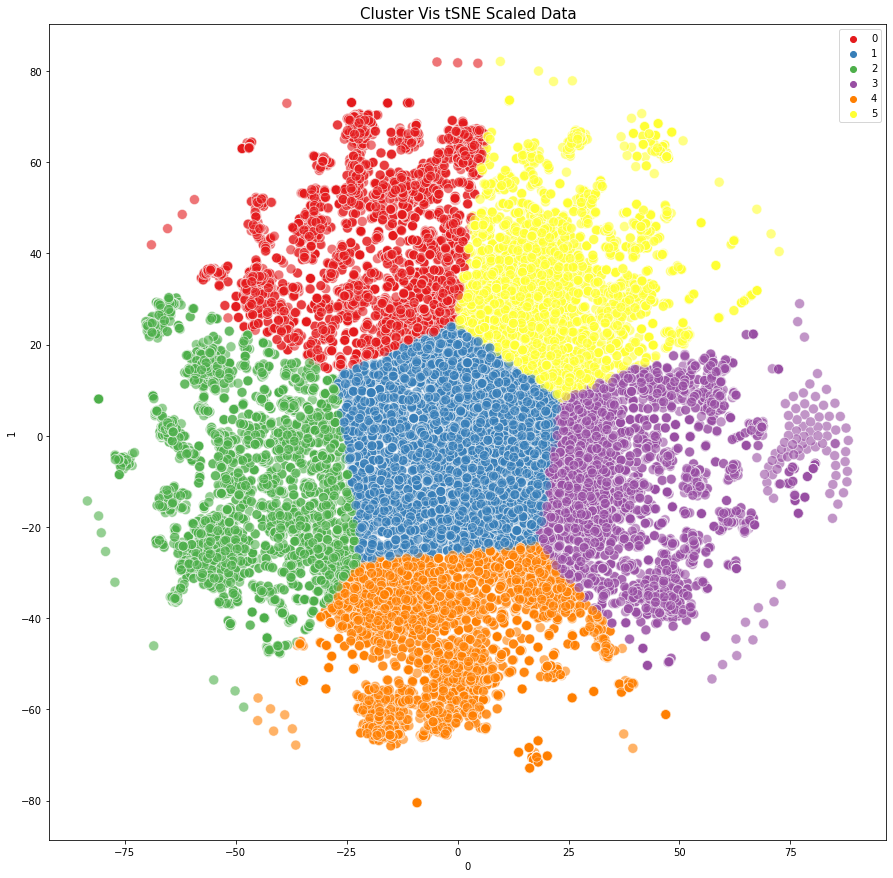

In [55]:
plt.figure(figsize = (15,15))
sns.scatterplot(x = clusters_tsne_scale.iloc[:,0],y = clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()

In [57]:
clusters_tsne_scale['top_ten_terms'] = top_terms_text

In [59]:
clusters_tsne_scale.groupby('tsne_clusters').count()['top_ten_terms']

tsne_clusters
0    3570
1    4291
2    3902
3    3753
4    4098
5    3714
Name: top_ten_terms, dtype: int64

In [71]:
a = clusters_tsne_scale[clusters_tsne_scale['tsne_clusters']==2].copy()
for i in a.loc[:,'top_ten_terms']:
    print(i)

mas,financieras,x,operaciones,impuesto,permanente,temporal,asi,gravaron,ocurrio
electo,serias,empalme,dio,gustavo,petro,presidente,equipo,gobierno,alertas
tarde,base,aebu,publicos,reunion,privados,llevara,definir,cabo,sindicatos
describir,momento,inusual,posesion,podria,cultural,sera,presidente,asi,oficial
mostro,idea,martes,fiscal,bajar,decidida,ministra,transmitir,deficit,intento
electo,avanzando,presidencial,posesion,gustavo,petro,presidente,continuan,preparativos,tendra
bancos,ladron,miami,supervisada,tras,robo,encontraba,jul,efe,libertad
montevideo,bancarios,uruguay,trabajadores,ago,asociacion,afiliados,banca,efe,privada
colombiano,retos,destaco,ignacio,grupo,moderador,presidente,gaitan,espacio,grandes
monte,continuaran,aebu,radio,juan,dijo,fernandez,dias,carlo,dirigente
primer,comienza,anos,izquierda,mandato,gustavo,colombia,petro,cuatro,presidente
primer,vivio,dia,posesiono,colombia,gustavo,petro,historico,presidente,mandatario
primer,izquierda,domingo,gustavo,colombia,petro,gob